# eMERLIN Metadata in the CAOM Model 

This notebook will demonstrate the process for:
- Downloading e-MERLIN data
- Creating metadata from e-MERLIN measurement sets, images, plots, etc.
- Uploading aforementioned metadata to a relational database
- Querying the data via TAP
- Analysing the gaps in CAOM for e-MERLIN metadata

In [1]:
import wget

import matplotlib.pyplot as plt
import numpy as np
import pyvo as vo

import ADQL_queries
from emerlin2caom2 import main_app
import plotting_sim_results as psr

data_update using version casarundata-2025.01.22-1.tar.gz, acquiring the lock ... 
'str' object has no attribute 'append'


2025-05-12 14:45:06	SEVERE	::casa	
2025-05-12 14:45:06	SEVERE	::casa	ERROR! Unexpected exception while doing auto updates or checking on the status of the data at measurespath
2025-05-12 14:45:06	SEVERE	::casa	visit https://casadocs.readthedocs.io/en/stable/notebooks/external-data.html for more information
2025-05-12 14:45:06	SEVERE	::casa	


## Setting up the Metadata Creation
The settings file for the metadata generation code houses all required user interaction including:
- The input data location
- The output metadata location
- The database url
- Required certificates
- Options for upload/replacement of metadata

In [30]:
# emerlin_data = wget.download("https://www.e-merlin.ac.uk/distribute/CY8/TS8004/TS8004_C_001_20190801.tar")
emerlin_data = '/TS8004_C_001_20190801'


In [31]:
emerlin_data_loc = "/home/h14471mj/e-merlin/data"
settings_file = "/home/h14471mj/e-merlin/em_github/emerlin2caom/emerlin2caom2/settings_file.py"
xml_dir = "/home/h14471mj/e-merlin/metadata{}".format(emerlin_data)
upload = 'True'
replace_old_data = 'True'
base_url = "http://localhost:8080/observations"
rootca = '/etc/ssl/certs/rootCA.pem'

In [27]:
def alter_settings_file(emerlin_data_loc, emerlin_data, settings_file, xml_dir, upload=True, replace_old_data=True,
                       base_url="http://localhost:8080/observations", rootca="/etc/ssl/certs/rootCA.pem"):
    settings_file_text = """
storage_name = '{6}{0}'
xmldir = '{1}'
upload = {2}
replace_old_data = {3}
base_url = '{4}'
rootca = '{5}'
""".format(emerlin_data, xml_dir, upload, replace_old_data, base_url, rootca, emerlin_data_loc)
    with open(settings_file, 'w') as f:
        f.write(settings_file_text)

In [32]:
alter_settings_file(emerlin_data_loc, emerlin_data, settings_file, xml_dir)

## Metadata Creation and Upload

In [27]:
meta = main_app.EmerlinMetadata()
meta.build_metadata()

2025-05-12 13:58:28	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on /home/h14471mj/e-merlin/data/TS8004_C_001_20190801/TS8004_C_001_20190801_avg.ms...
2025-05-12 13:58:28	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...


5f61f98b-ec29-4048-9999-b0bd76d27e7f has been deleted.
TS8004_C_001_20190801_Mk2 deleted.
TS8004_C_001_20190801_Mk2 ingested.
1612ad75-b86b-47c4-9697-c74a1edba052 has been deleted.
TS8004_C_001_20190801_Kn deleted.
TS8004_C_001_20190801_Kn ingested.
8a5bef06-e0c7-42ec-a380-5bb127d5fc09 has been deleted.
TS8004_C_001_20190801_De deleted.
TS8004_C_001_20190801_De ingested.
e47c66a1-eca6-4d08-b87d-ef016455d42c has been deleted.
TS8004_C_001_20190801_Pi deleted.
TS8004_C_001_20190801_Pi ingested.
938d6cd2-1ece-4bad-978a-abc567d84623 has been deleted.
TS8004_C_001_20190801_Da deleted.
TS8004_C_001_20190801_Da ingested.
06d76618-7e78-40ac-8f92-cfe12a1a15ef has been deleted.
TS8004_C_001_20190801_Cm deleted.
TS8004_C_001_20190801_Cm ingested.
55a72315-d9e6-4a3b-9e72-fd492130f6e0 has been deleted.
TS8004_C_001_20190801_1331+3030 deleted.
TS8004_C_001_20190801_1331+3030 ingested.
7ab0b70b-82ae-4ed0-a0e6-bf149ec34071 has been deleted.
TS8004_C_001_20190801_1252+5634 deleted.
TS8004_C_001_2019080

2025-05-12 13:58:29	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on /home/h14471mj/e-merlin/data/TS8004_C_001_20190801/TS8004_C_001_20190801_avg.ms...
2025-05-12 13:58:29	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...


-166.890475416667
-164.281394679167


2025-05-12 13:58:55	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on /home/h14471mj/e-merlin/data/TS8004_C_001_20190801/splits/TS8004_C_001_20190801_1252+5634.ms/...
2025-05-12 13:58:55	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...


9383d843-78f2-4220-84c4-d32860c58a13 has been deleted.
TS8004_C_001_20190801 deleted.
TS8004_C_001_20190801 ingested.


## Querying the Metadata via TAP

In [28]:
query_url = base_url.replace('observations', 'tap')
service = vo.dal.TAPService(query_url)
resultset = service.search("SELECT * FROM derivedobservation")
derived_observation_id = resultset.to_table()['id'][0]

In [29]:
resultset = service.search("""
    SELECT t.name, p.* FROM Target t 
    JOIN Observation o ON o.target_id = t.id 
    JOIN point p ON t.id = p.id
    WHERE EXISTS (
        SELECT 1
        FROM Derivedobservation d 
        WHERE d.id = '{}' AND d.members LIKE '%' || o.uri || '%'
        )
;""".format(derived_observation_id))

In [30]:
resultset.to_table()

name,cval1,cval2,id,polygon_id
object,float64,float64,int64,int64
1302+5748,202.78453041666666,30.509155277777786,8,--
0319+4130,193.10952458333307,56.57208000000002,9,--
1407+2827,195.71860532083335,57.81044703333334,10,--


## Suitability of the CAOM for eMERLIN

Overlap between the metadata required to complete all 16 use cases for eMerlin metadata and the CAOM

In [12]:
full_stack = psr.create_uc_main(psr.requirements, psr.use_case_dict)
alt_stack = psr.create_uc_main(psr.requirements, psr.use_case_dict_actual)
tot_stack =  full_stack + alt_stack

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

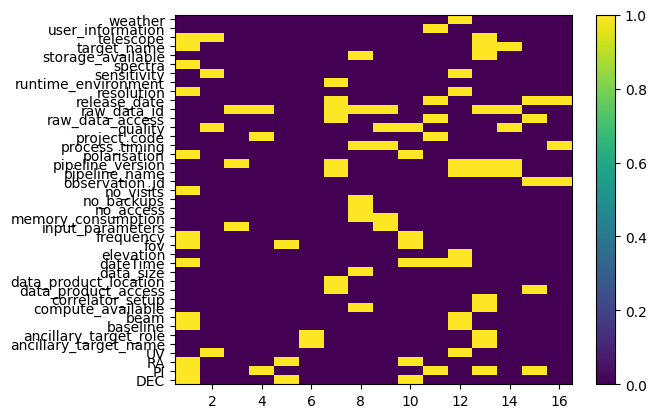

In [4]:
psr.create_graph(psr.X, psr.requirements, full_stack)

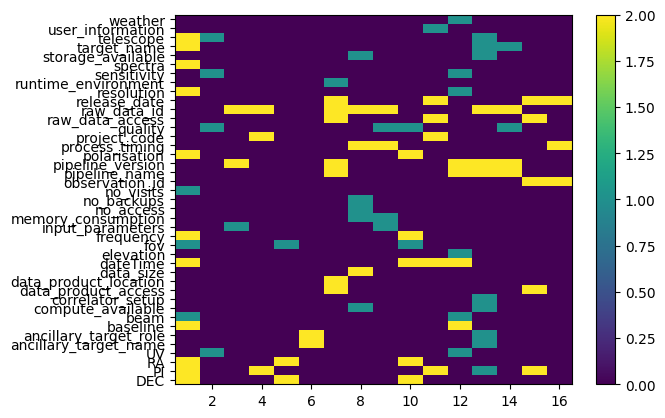

In [16]:
psr.create_graph(psr.X, psr.requirements, tot_stack)

In [ ]:
# maybe add the bar chart here, not essential

## Use Case Queries

In [ ]:
e-merlin_data = 

for data_name in 

alter_settings_file(emerlin_data_loc, emerlin_data, settings_file, xml_dir)

In [ ]:
res_tab = ADQL_queries.use_case_queries(base_url.replace('observations', 'tap'), [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [22]:
def create_graph_results(results, vmax=None):
    Y = list(results.keys())
    X = list(results[Y[0]].keys())
    Z = []
    for x in Y:
        Z.extend(list(results[x].values()))
        
    x_ax, y_ax = np.meshgrid(X,Y)
    z_ar = np.asarray(Z)
    z_ax = z_ar.reshape(len(Y), len(X))
    
    if vmax == None:
        plt.pcolormesh(X,Y,z_ax)
    else:
        plt.pcolormesh(X,Y,z_ax, vmax=vmax)
    plt.colorbar()
    plt.show()

In [19]:
results = {'TS8004': {'1': 9, '3': 4, '4': 4, '5': 7, '6': 54, '7': 390, '8': 390, '9': 390, '10': 2, '11': 390, '12': 29, '13': 390, '14': 390, '15': 390, '16': 390}, 'CY1003': {'1': 13, '3': 6, '4': 6, '5': 5, '6': 32, '7': 236, '8': 236, '9': 236, '10': 2, '11': 236, '12': 19, '13': 236, '14': 236, '15': 236, '16': 236}, 'CY11218': {'1': 13, '3': 6, '4': 6, '5': 5, '6': 37, '7': 263, '8': 263, '9': 263, '10': 2, '11': 263, '12': 22, '13': 263, '14': 263, '15': 263, '16': 263}, 'CY14025_c': {'1': 13, '3': 6, '4': 6, '5': 5, '6': 32, '7': 236, '8': 236, '9': 236, '10': 2, '11': 236, '12': 19, '13': 236, '14': 236, '15': 236, '16': 236}, 'CY14025_l': {'1': 13, '3': 6, '4': 6, '5': 5, '6': 43, '7': 313, '8': 313, '9': 313, '10': 2, '11': 313, '12': 24, '13': 313, '14': 313, '15': 313, '16': 313}, 'CY16204': {'1': 13, '3': 6, '4': 6, '5': 5, '6': 32, '7': 236, '8': 236, '9': 236, '10': 2, '11': 236, '12': 19, '13': 236, '14': 236, '15': 236, '16': 236}, 'CY9207': {'1': 13, '3': 6, '4': 6, '5': 7, '6': 54, '7': 390, '8': 390, '9': 390, '10': 2, '11': 390, '12': 29, '13': 390, '14': 390, '15': 390, '16': 390}, 'CY10206': {'1': 13, '3': 6, '4': 6, '5': 4, '6': 32, '7': 236, '8': 236, '9': 236, '10': 2, '11': 236, '12': 19, '13': 236, '14': 236, '15': 236, '16': 236}}
timing = {'TS8004': {'1': 0.06445145606994629, '3': 0.023183107376098633, '4': 0.02767348289489746, '5': 0.023070812225341797, '6': 0.020480871200561523, '7': 0.0232541561126709, '8': 0.020712852478027344, '9': 0.02303314208984375, '10': 0.028107166290283203, '11': 0.026731491088867188, '12': 0.03821206092834473, '13': 0.028374671936035156, '14': 0.027465343475341797, '15': 0.0274045467376709, '16': 0.019715309143066406}, 'CY1003': {'1': 0.07904171943664551, '3': 0.021369457244873047, '4': 0.01930546760559082, '5': 0.022382259368896484, '6': 0.021665334701538086, '7': 0.027602672576904297, '8': 0.022768497467041016, '9': 0.021407604217529297, '10': 0.023614168167114258, '11': 0.020392894744873047, '12': 0.04464435577392578, '13': 0.0218656063079834, '14': 0.026551485061645508, '15': 0.02443385124206543, '16': 0.02090930938720703}, 'CY11218': {'1': 0.06595778465270996, '3': 0.024020910263061523, '4': 0.01722574234008789, '5': 0.021221637725830078, '6': 0.016554832458496094, '7': 0.025606393814086914, '8': 0.02237701416015625, '9': 0.022060394287109375, '10': 0.02105998992919922, '11': 0.01958918571472168, '12': 0.04220938682556152, '13': 0.020635366439819336, '14': 0.020810842514038086, '15': 0.02145981788635254, '16': 0.02327871322631836}, 'CY14025_c': {'1': 0.06888151168823242, '3': 0.01890730857849121, '4': 0.019298791885375977, '5': 0.0201418399810791, '6': 0.01732492446899414, '7': 0.025191307067871094, '8': 0.023247957229614258, '9': 0.023169994354248047, '10': 0.02466273307800293, '11': 0.020671367645263672, '12': 0.04000973701477051, '13': 0.021537303924560547, '14': 0.024750471115112305, '15': 0.021532535552978516, '16': 0.025246858596801758}, 'CY14025_l': {'1': 0.06942105293273926, '3': 0.022408485412597656, '4': 0.018125534057617188, '5': 0.02237534523010254, '6': 0.019048213958740234, '7': 0.021419286727905273, '8': 0.01875782012939453, '9': 0.019910573959350586, '10': 0.02479863166809082, '11': 0.02427530288696289, '12': 0.043016672134399414, '13': 0.02400040626525879, '14': 0.024624109268188477, '15': 0.023432493209838867, '16': 0.026808977127075195}, 'CY16204': {'1': 0.06470942497253418, '3': 0.018603086471557617, '4': 0.01874709129333496, '5': 0.01884746551513672, '6': 0.02005147933959961, '7': 0.033380746841430664, '8': 0.017855167388916016, '9': 0.02201080322265625, '10': 0.022396087646484375, '11': 0.02003931999206543, '12': 0.04009366035461426, '13': 0.021243572235107422, '14': 0.01935863494873047, '15': 0.02162647247314453, '16': 0.024430036544799805}, 'CY9207': {'1': 0.07726931571960449, '3': 0.022307157516479492, '4': 0.020117759704589844, '5': 0.0190427303314209, '6': 0.01822209358215332, '7': 0.022892236709594727, '8': 0.025417327880859375, '9': 0.02218317985534668, '10': 0.02363133430480957, '11': 0.02496814727783203, '12': 0.04643964767456055, '13': 0.026227235794067383, '14': 0.022897005081176758, '15': 0.022290945053100586, '16': 0.022180557250976562}, 'CY10206': {'1': 0.06338262557983398, '3': 0.01908111572265625, '4': 0.02315545082092285, '5': 0.0213015079498291, '6': 0.017742633819580078, '7': 0.026762723922729492, '8': 0.020709753036499023, '9': 0.019874095916748047, '10': 0.021866798400878906, '11': 0.021535634994506836, '12': 0.037351131439208984, '13': 0.02033400535583496, '14': 0.02464771270751953, '15': 0.022148609161376953, '16': 0.019672155380249023}}

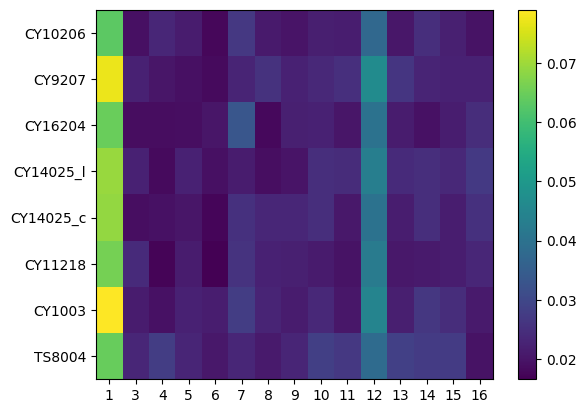

In [23]:
create_graph_results(timing)

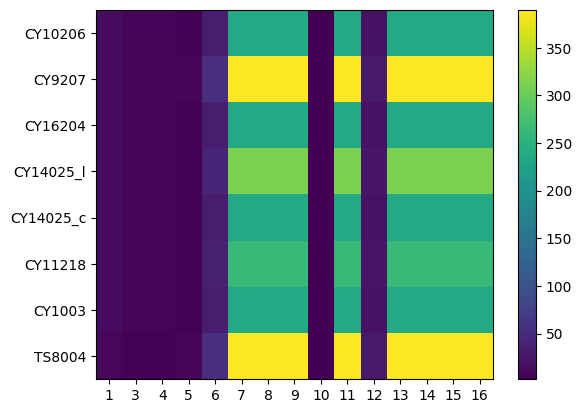

In [24]:
create_graph_results(results)

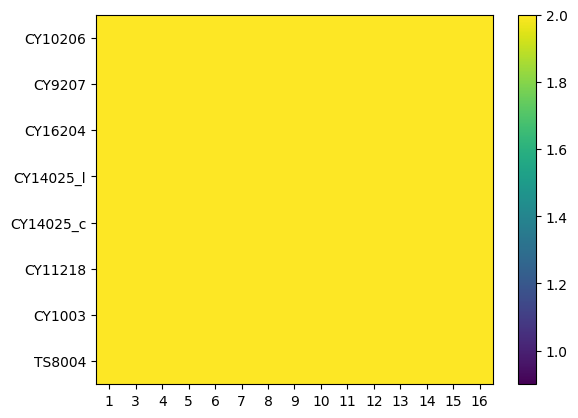

In [25]:
create_graph_results(results, vmax=1)

In [43]:
res_tab

({'1': 0.06950545310974121,
  '3': 0.027207612991333008,
  '4': 0.021758317947387695,
  '5': 0.03123760223388672,
  '6': 0.019783496856689453,
  '7': 0.020366907119750977,
  '8': 0.021644115447998047,
  '9': 0.023264408111572266,
  '10': 0.02577352523803711,
  '11': 0.022838354110717773,
  '12': 0.04427766799926758,
  '13': 0.021491050720214844,
  '14': 0.026223421096801758,
  '15': 0.02239990234375,
  '16': 0.02476358413696289},
 {'1': 11,
  '3': 6,
  '4': 6,
  '5': 1,
  '6': 6,
  '7': 44,
  '8': 44,
  '9': 44,
  '10': 2,
  '11': 44,
  '12': 8,
  '13': 44,
  '14': 44,
  '15': 44,
  '16': 44})

In [41]:
print(list(range(1,17)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
